Computer Vision Course Work

In [ ]:
#import package
from google.colab import drive
#mount my drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python==4.4.0.46

In [ ]:
#import package
import os
#setup paths
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_Folder' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
#print content
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset', 'Models', 'Videos']


In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE2 = 'Colab Notebooks/Computer Vision/CW_Folder/CW_Dataset' 
GOOGLE_DRIVE_PATH2 = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE2)
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH2, 'CW_Dataset.zip')
# Copy it to Colab
!cp '{zip_path}' .
# Unzip it
!yes|unzip -q CW_Dataset.zip
# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [ ]:
#import packages
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%matplotlib inline
import torch

In [ ]:
#setup train folder path
train_data = 'train'
#create empty list
images = []
#extract files
file_names = [file for file in sorted(os.listdir(os.path.join(train_data))) if file.endswith('.jpg')]
#append files to empty list
for file in file_names:
  images.append(io.imread(os.path.join(train_data, file)))

In [ ]:
#setup label folder path
train_labels = 'labels/list_label_train.txt'
#bring in file
labels = np.genfromtxt(train_labels)
#convert to list
labels = labels.tolist()
#extract second element in each list
labels = [item[1] for item in labels]

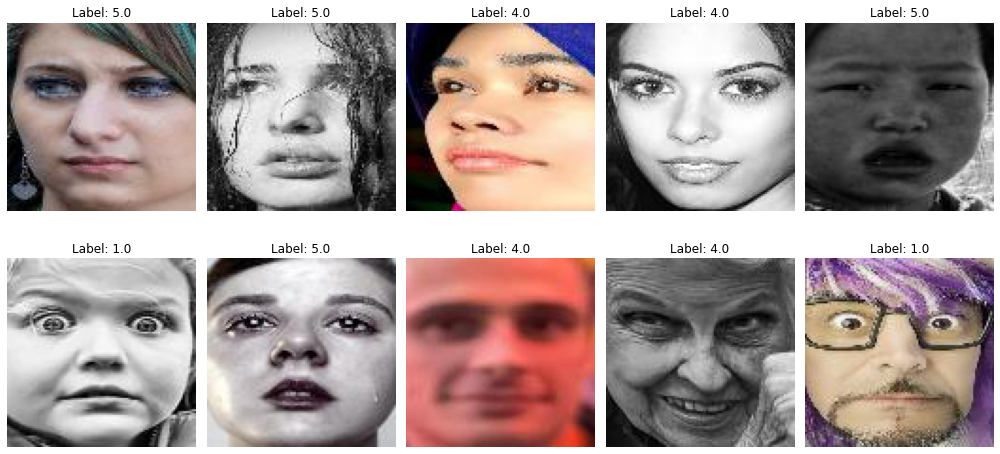

In [ ]:
#view first 10 images with their labels
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()
for i in range(10):
    ax[i].imshow(images[i])
    ax[i].set_title(f'Label: {labels[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
print(Counter(labels))

Counter({4.0: 4772, 7.0: 2524, 5.0: 1982, 1.0: 1290, 3.0: 717, 6.0: 705, 2.0: 281})


In [ ]:
_image = np.array(images)
_image.shape

(12271, 100, 100, 3)

In [ ]:
image = torch.from_numpy(_image)
image = image.permute(0,3, 1, 2)
images2=image.numpy()
labels=np.asarray(labels)

In [ ]:
images2[1]
# confirm pixel range is 0-255
print('Data Type: %s' % images2[1].dtype)
print('Min: %.3f, Max: %.3f' % (images2[1].min(), images2[1].max()))

Data Type: uint8
Min: 0.000, Max: 255.000


In [ ]:
#convert from integers to floats
images3 = images2.astype('float32')
images3 /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (images3[1].min(), images3[1].max()))

Min: 0.000, Max: 1.000


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(images3, labels, test_size=0.2, shuffle=True, stratify=labels)

# CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [ ]:
print('Training set size (num images)', len(X_train))
print('Testing set size (num images)', len(X_valid))
print('Training set size (num images)', len(y_train))
print('Testing set size (num images)', len(y_valid))

Training set size (num images) 9816
Testing set size (num images) 2455
Training set size (num images) 9816
Testing set size (num images) 2455


In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 
dev = "cpu"

In [ ]:
X_train = torch.FloatTensor(X_train).to(dev)
y_train = torch.FloatTensor(np.array(y_train)).to(dev)

X_valid = torch.FloatTensor(X_valid).to(dev)
y_valid = torch.FloatTensor(np.array(y_valid)).to(dev)

train = torch.utils.data.TensorDataset(X_train,y_train)
valid = torch.utils.data.TensorDataset(X_valid,y_valid) 

## create data loaders for pytorch
trainloader = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = False)
validloader = torch.utils.data.DataLoader(valid, batch_size = 10, shuffle = False)

In [ ]:
y_train

tensor([1., 4., 7.,  ..., 5., 5., 4.])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16*22*22, 28)
        self.batchnorm1 = nn.BatchNorm1d(28)
        self.fc2 = nn.Linear(28, 14)
        self.batchnorm2 = nn.BatchNorm1d(14)
        self.dropout = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(14, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*22*22)
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net = Net()

params = list(net.parameters())
print('Number of elements in params =', len(params))
print('conv1\'s weights size =', params[0].size())
print('conv1\'s biases size =', params[1].size())
print('conv2\'s weights size =', params[2].size())


params = list(net.parameters())
print('Number of elements in params =', len(params))
print('conv1\'s weights size =', params[0].size())
print('conv1\'s biases size =', params[1].size())
print('conv2\'s weights size =', params[2].size())

Number of elements in params = 14
conv1's weights size = torch.Size([32, 3, 5, 5])
conv1's biases size = torch.Size([32])
conv2's weights size = torch.Size([16, 32, 5, 5])
Number of elements in params = 14
conv1's weights size = torch.Size([32, 3, 5, 5])
conv1's biases size = torch.Size([32])
conv2's weights size = torch.Size([16, 32, 5, 5])


In [27]:
# training and validating MLP model

model = Net().to(dev)

# optimizer with adjustable learning rate
#optimizer=torch.optim.Adagrad(model.parameters(),lr=0.0001)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.8)

# loss function for classification
criterion = nn.CrossEntropyLoss() 

import time

t0 = time.time()

for epoch in range(50):  # loop over the training set two times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.long()-1)
        loss.backward()
        optimizer.step()

        # print statistics (loss.item() returns the mean loss in the mini-batch)
        running_loss += loss.item()
        if i % 900 == 899:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training: total time in seconds =', time.time() - t0)

[1,   900] loss: 5.481
[2,   900] loss: 5.598
[3,   900] loss: 5.246
[4,   900] loss: 4.716
[5,   900] loss: 4.428
[6,   900] loss: 4.220
[7,   900] loss: 3.987
[8,   900] loss: 3.837
[9,   900] loss: 3.680
[10,   900] loss: 3.470
[11,   900] loss: 3.356
[12,   900] loss: 3.251
[13,   900] loss: 3.130
[14,   900] loss: 2.905
[15,   900] loss: 2.793
[16,   900] loss: 2.638
[17,   900] loss: 2.613
[18,   900] loss: 2.488
[19,   900] loss: 2.383
[20,   900] loss: 2.474
[21,   900] loss: 3.173
[22,   900] loss: 2.276
[23,   900] loss: 2.027
[24,   900] loss: 1.898
[25,   900] loss: 1.848
[26,   900] loss: 1.769
[27,   900] loss: 1.699
[28,   900] loss: 1.693
[29,   900] loss: 1.605
[30,   900] loss: 1.584
[31,   900] loss: 1.725
[32,   900] loss: 1.466
[33,   900] loss: 2.363
[34,   900] loss: 2.681
[35,   900] loss: 2.491
[36,   900] loss: 2.394
[37,   900] loss: 2.230
[38,   900] loss: 2.240
[39,   900] loss: 2.120
[40,   900] loss: 2.049
[41,   900] loss: 2.041
[42,   900] loss: 1.923
[

In [28]:
# Estimate average accuracy
correct = 0
total = 0

with torch.no_grad():             # Avoid backprop at test 
    for i, data in enumerate(validloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        _,predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels-1).sum().item()
print(f"validate images: {100 * correct / total}%")

validate images: 59.30753564154786%


In [29]:
model_save_name = 'CNN.pt'
path = F"/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder/Models/{model_save_name}" 
torch.save(model, path)

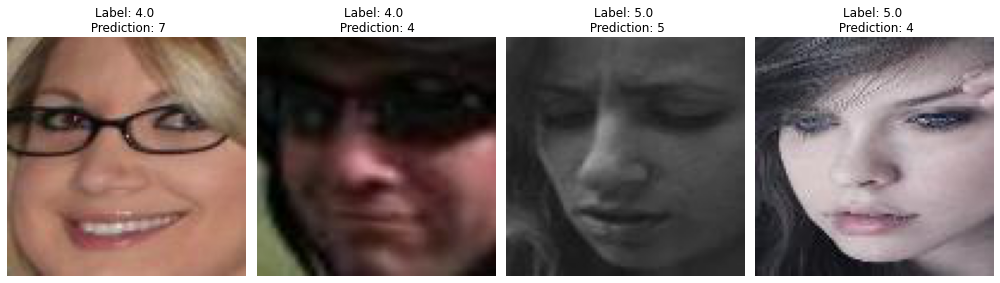

In [31]:
test1 = X_valid.numpy()
test1 = torch.from_numpy(test1)
test2 = test1.permute(0,2, 3, 1)
test3 = test2.numpy()

fig, axes = plt.subplots(1, 4, 
figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(4):
    ax[i].imshow(test3[i])
    ax[i].set_title(f'Label: {y_valid[i]} \n Prediction: {predicted[i]+1}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()